In [4]:
from dolfinx import fem, mesh, io
import dolfinx.fem.petsc as petsc
from petsc4py import PETSc
import numpy as np
from mpi4py import MPI
import ufl
import matplotlib.pyplot as plt
from typing import Any
import gotranx

In [5]:
%reload_ext autoreload 
import gotranx
import os
from pathlib import Path
import op_splitting as op 

scheme = gotranx.schemes.Scheme.generalized_rush_larsen
ode = gotranx.load_ode(str(Path.cwd().parent) + "/odes/fitzhughnagumo.ode")

2024-11-26 12:46:26 [info     ] Load ode /Users/alexanderhatle/Documents/Computing the Electrical Activity in the Heart/odes/fitzhughnagumo.ode
2024-11-26 12:46:26 [info     ] Num states 2                  
2024-11-26 12:46:26 [info     ] Num parameters 11             


In [108]:
lam = 1
T = 10
def initial_s(x):
    return 0*x[0]

def initial_v(x):
    return -85*x[0]+50

def solve_fitz(h, dt, ode, scheme, theta, lagrangeOrder, vtxTitle=None):
    gamma = dt * lam / (1+lam)
    N = int(np.ceil(1/h))

    # Create square domain and function space
    domain = mesh.create_unit_square(MPI.COMM_WORLD, N, N, mesh.CellType.quadrilateral)
    V = fem.functionspace(domain, ("Lagrange", lagrangeOrder))
    t = fem.Constant(domain, 0.0)
    x = ufl.SpatialCoordinate(domain)

    # Define stimulating current
    I_stim = 0 * ufl.pi**2 * lam/(1+lam) * ufl.sin(t) * ufl.cos(2*ufl.pi*x[0]) * ufl.cos(2*ufl.pi*x[1])
    
    # Intialize states
    vn = fem.Function(V)
    vn.name = "vn"
    vn.interpolate(initial_v)

    sn = fem.Function(V)
    sn.name = "sn"
    sn.interpolate(initial_s)

    # Setup PDE solver
    v = ufl.TrialFunction(V)
    phi = ufl.TestFunction(V)
    dx = ufl.dx(domain=domain)
    a = phi * v * dx + gamma * theta * ufl.dot(ufl.grad(phi), ufl.grad(v)) * dx
    L = phi * (vn + dt * I_stim) * dx - gamma * (1-theta) * ufl.dot(ufl.grad(phi), ufl.grad(vn)) * dx
    compiled_a = fem.form(a)
    A = petsc.assemble_matrix(compiled_a)
    A.assemble()

    compiled_L = fem.form(L)
    b = fem.Function(V)
    
    solver = PETSc.KSP().create(domain.comm)
    solver.setOperators(A)
    solver.setType(PETSc.KSP.Type.PREONLY)
    solver.getPC().setType(PETSc.PC.Type.LU)
    
    if vtxTitle:
        vtx = io.VTXWriter(MPI.COMM_WORLD, vtxTitle + ".bp", [vn], engine="BP4")
        vtx.write(0.0)

    # Setup ODE solver
    code = gotranx.cli.gotran2py.get_code(ode, scheme = [scheme])
    Path("model.py").write_text(code)
    model: dict[str, Any] = {}
    exec(code, model)

    init = model["init_state_values"]()
    params = model["init_parameter_values"]()
    values = np.zeros((len(init), len(vn.x.array)))
    v_index = model["state_index"]("v")
    s_index = model["state_index"]("s")

    odesolver = model["generalized_rush_larsen"]

    # Set initial states
    values[v_index, :] = vn.x.array
    values[s_index, :] = sn.x.array

    while t.value < T:
        # Step 1
        values[:] = odesolver(values, t.value, theta*dt, params)
        t.value += theta * dt

        # Step 2
        vn.x.array[:] = values[v_index,:]
        b.x.array[:] = 0
        petsc.assemble_vector(b.vector, compiled_L)
        
        solver.solve(b.vector, vn.vector)
        vn.x.scatter_forward()
        values[v_index,:] = vn.x.array[:]

        # Step 3
        if theta < 1.0:
            values[:] = odesolver(values, t.value, (1-theta) * dt, params)
            t.value += (1-theta) * dt
        vn.x.array[:] = values[v_index,:]
        if vtxTitle:
            vtx.write(t.value)
    return vn, x, t

In [109]:
solve_fitz(0.1, 0.01, ode, scheme, 0.5, 2, vtxTitle="fitz")

(Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, quadrilateral, 1, gll_warped, unset, False, float64, []), (2,)), 76), Basix element (P, quadrilateral, 2, gll_warped, unset, False, float64, [])), 224),
 SpatialCoordinate(Mesh(blocked element (Basix element (P, quadrilateral, 1, gll_warped, unset, False, float64, []), (2,)), 76)),
 Constant(Mesh(blocked element (Basix element (P, quadrilateral, 1, gll_warped, unset, False, float64, []), (2,)), 76), (), 75))

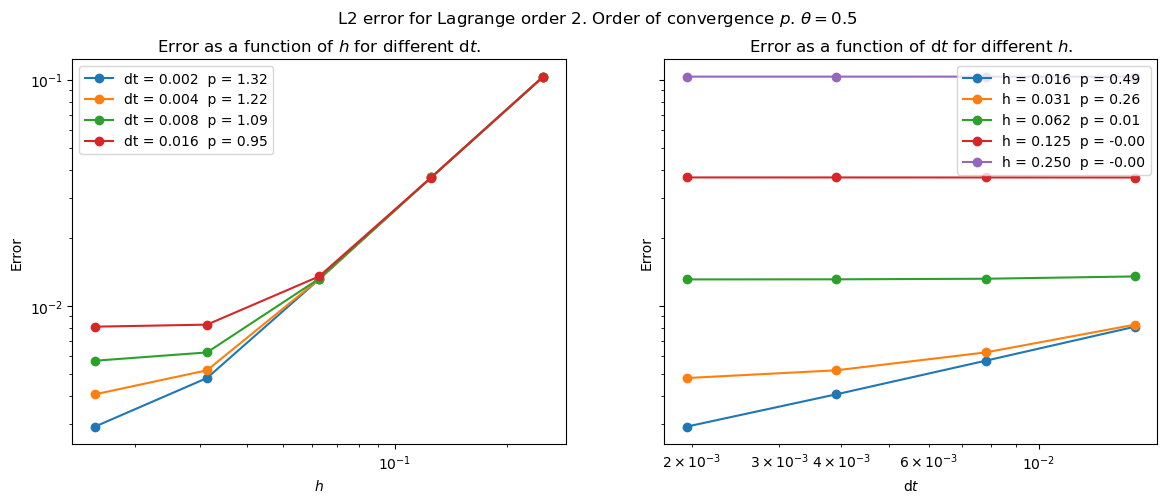

In [49]:
%autoreload

op.analyse_error(5, 4, startSpatial=1, startTemporal=5, ode=ode, scheme = scheme, theta=0.5, lagrangeOrder=2)

In [52]:
%autoreload
import gotranx
ode = gotranx.load_ode("/Users/alexanderhatle/Documents/Computing the Electrical Activity in the Heart/odes/simple.ode")
op.solve(0.1,0.01, ode, scheme, 0.5,1)

2024-11-12 14:02:40 [info     ] Load ode /Users/alexanderhatle/Documents/Computing the Electrical Activity in the Heart/odes/simple.ode
2024-11-12 14:02:40 [info     ] Num states 2                  
2024-11-12 14:02:40 [info     ] Num parameters 0              
ODE(simple, num_states=2, num_parameters=0)


(Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, quadrilateral, 1, gll_warped, unset, False, float64, []), (2,)), 48), Basix element (P, quadrilateral, 1, gll_warped, unset, False, float64, [])), 140),
 SpatialCoordinate(Mesh(blocked element (Basix element (P, quadrilateral, 1, gll_warped, unset, False, float64, []), (2,)), 48)),
 Constant(Mesh(blocked element (Basix element (P, quadrilateral, 1, gll_warped, unset, False, float64, []), (2,)), 48), (), 47))

In [20]:
import gotranx
from pathlib import Path

In [4]:
model_path = Path("/Users/alexanderhatle/Documents/Computing the Electrical Activity in the Heart/operator splitting/simple.py")
if not model_path.is_file():
    ode = gotranx.load_ode("/Users/alexanderhatle/Documents/Computing the Electrical Activity in the Heart/odes/simple.ode")
    code = gotranx.cli.gotran2py.get_code(
        ode, scheme=[gotranx.schemes.Scheme.forward_explicit_euler, gotranx.schemes.Scheme.generalized_rush_larsen]
    )
    model_path.write_text(code)

In [2]:
import monodomain 

In [6]:
%autoreload
monodomain.translateODE("fitzhughnagumo", [gotranx.schemes.Scheme.forward_explicit_euler, gotranx.schemes.Scheme.generalized_rush_larsen])

ODE already translated


In [20]:
def initial_v(x):
    return 0*x[0]

def initial_s(x):
    return -np.cos(2*np.pi * x[0]) * np.cos(2*np.pi * x[1])

In [ ]:
%autoreload

h = 0.01
dt = 0.001
theta = 0.5
pde = monodomain.PDESolver(h, dt, theta, M = 1, lam = 1)

N = int(np.ceil(1/h))
domain = mesh.create_unit_square(MPI.COMM_WORLD, N, N, mesh.CellType.quadrilateral)
pde.set_mesh(domain, lagrange_order=1)
pde.initialize_vn(initial_v)
I_stim = 8 * ufl.pi**2 * pde.lam/(1+pde.lam) * ufl.sin(pde.t) * ufl.cos(2*ufl.pi*pde.x[0]) * ufl.cos(2*ufl.pi*pde.x[1])

pde.set_stimulus(I_stim)
pde.setup_solver()

sn = pde.interpolate_func(initial_s)
ode = monodomain.ODESolver(scheme="forward_explicit_euler", initial_v=pde.vn, initial_states=[sn], state_names=["s"])

solver = monodomain.MonodomainSolver(pde, ode)
vn, x, t = solver.solve(T=1)
v_ex = ufl.cos(2 * ufl.pi * x[0]) * ufl.cos(2 * ufl.pi * x[1]) * ufl.sin(t) # Exact solution at final timestep

comm = vn.function_space.mesh.comm
error = fem.form(ufl.sqrt((vn - v_ex)**2) * ufl.dx) # L2 error
E = np.sqrt(comm.allreduce(fem.assemble_scalar(error), MPI.SUM))

1.0009999999999453
0.010791415220937543
